- 事故種別(基本)名について
  "医師搬送"は除外しても良さそう(医師を運んだだけ？、傷病名の記載もない)
  "転院搬送"も関係なさそう

- 収容機関名
  "不搬送"はいらないのでは？
  →不搬送を除外すると、傷病名が空欄は無くなったし、事故種別の医師搬送もなくなった

- 傷病名(大, 中, 小)分類(国)名
  一旦いらないかな

In [ ]:
fakfewafkawe@fea@af@e

In [6]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(''), '../src/'))
import pandas as pd

def clean_data(df):
    # 次の列の種類をstringに変更する: '覚知日付(元号年月日)'
    df = df.astype({'覚知日付(元号年月日)': 'string'})
    df = df.astype({'覚知日付(元号)名': 'string'})
    df = df.astype({'覚知日付(年)': 'string'})
    df = df.astype({'覚知日付(月)': 'string'})
    df = df.astype({'覚知日付(日)': 'string'})
    df = df.astype({'覚知時刻(時)': 'string'})
    df = df.astype({'覚知時刻(分)': 'string'})

    df["datestr"] = df["覚知日付(元号)名"] + df["覚知日付(年)"] +"年" + df["覚知日付(月)"] +"月"+ df["覚知日付(日)"]+"日" \
                    + " " + df["覚知時刻(時)"] + ":" + df["覚知時刻(分)"]
    df.drop(['覚知日付(元号年月日)','覚知日付(元号)名','覚知日付(年)',
             '覚知日付(月)','覚知日付(日)','覚知時刻(時)','覚知時刻(分)'],axis=1,inplace=True)
    import jp_datetime
    df["datetime"] = df["datestr"].apply(lambda x: 
                                         jp_datetime.parse_date(x,'%g%e年%m月%d日 %H:%M')
                                         )
    df.drop(['datestr'],axis=1,inplace=True)
    df = df.reindex(['datetime','出場隊名', '事故種別(基本)名', '覚知→現着(所要時間)', '覚知→病着(所要時間)', '年齢(歳)', '年齢区分名',
       '性別名', '傷病程度名', '傷病名', '傷病名大分類(国)名', '傷病名中分類(国)名', '傷病名小分類(国)名',
       '収容機関名', '行政区別区分名'], axis=1)
    

    # 病院に実際に来る場合を対象にしたいので、不搬送を除去
    df = df[df['収容機関名'] != "不搬送"]

    # 列を削除: '傷病名大分類(国)名'
    df = df.drop(columns=['傷病名大分類(国)名'])
    df = df.drop(columns=['傷病名中分類(国)名'])
    df = df.drop(columns=['傷病名小分類(国)名'])

    # count用に列を追加
    df["count"] = 1

    # 列で並べ替えます: 'datetime' (昇順)
    df = df.sort_values(['datetime'], ignore_index=True)
    
    return df

# excel形式のデータ読み込み
df = pd.concat(
    [pd.read_excel(r'../input/01_令和元年.xlsx'),
    pd.read_excel(r"../input/02_令和２年.xlsx"),
    pd.read_excel(r"../input/03_令和３年.xlsx"),
    pd.read_excel(r"../input/04_令和４年.xlsx"),
    pd.read_excel(r"../input/05_令和５年.xlsx")]
)
df_clean = clean_data(df.copy())
df_clean.head(3)
# df_clean.傷病名.to_csv("../output/傷病名一覧.csv",index=None)
# df_clean.to_pickle('../output/df_clean.pkl.gz', compression='gzip') # 圧縮有り

,datetime,出場隊名,事故種別(基本)名,覚知→現着(所要時間),覚知→病着(所要時間),年齢(歳),年齢区分名,性別名,傷病程度名,傷病名,収容機関名,行政区別区分名,count
0,2019-01-01 00:07:00,浜北救急隊,急病,8,40.0,68.0,高齢者,男,軽症,意識消失発作,浜松医大病院,浜北区,1
1,2019-01-01 00:19:00,高台救急隊,急病,8,23.0,4.0,乳幼児,男,軽症,熱性痙攣,浜松医大病院,中区,1
2,2019-01-01 00:21:00,中救急隊,転院搬送,6,31.0,6.0,乳幼児,女,中等症,インフルエンザ、嘔吐,浜松医大病院,中区,1


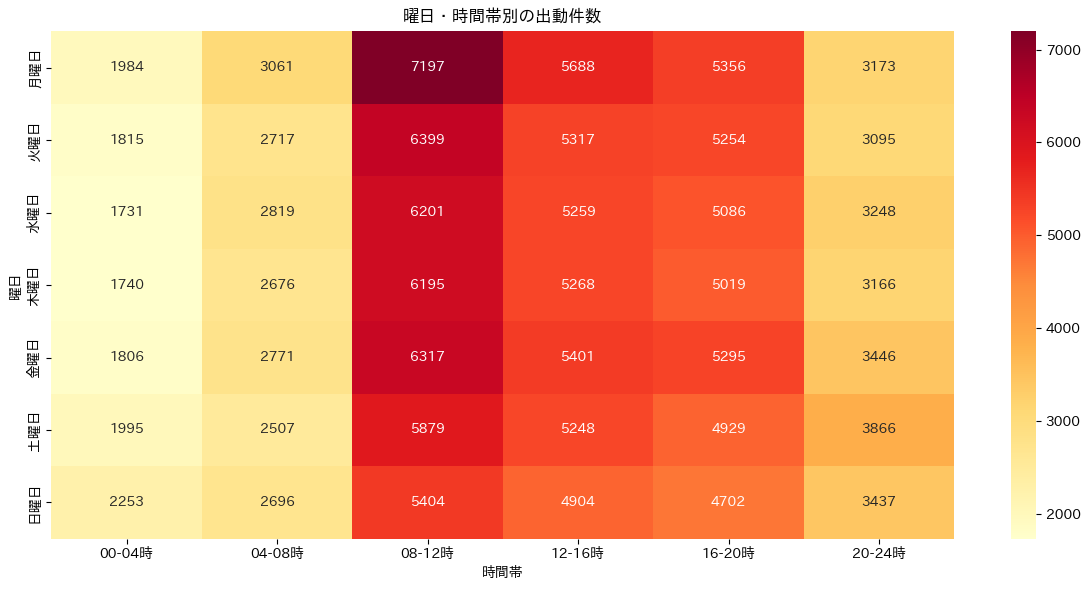


時間帯・曜日別の出動件数:
time_slot  00-04時  04-08時  08-12時  12-16時  16-20時  20-24時
weekday                                                  
月曜日          1984    3061    7197    5688    5356    3173
火曜日          1815    2717    6399    5317    5254    3095
水曜日          1731    2819    6201    5259    5086    3248
木曜日          1740    2676    6195    5268    5019    3166
金曜日          1806    2771    6317    5401    5295    3446
土曜日          1995    2507    5879    5248    4929    3866
日曜日          2253    2696    5404    4904    4702    3437


In [7]:
import os
import sys
import japanize_matplotlib
sys.path.append(os.path.join(os.path.abspath(''), '../src/'))
import pandas as pd
# 集計
df_clean = pd.read_pickle('../output/df_clean.pkl.gz', compression='gzip') # 圧縮有り
df_mod =  df_clean.copy()
df_mod.set_index(keys="datetime",inplace=True)
# 日付列から曜日を抽出
df_mod['weekday'] = df_mod.index.day_name()  # または .dt.weekday でも可
# 日本語の曜日表示にする場合
weekday_mapping = {
    'Monday': '月曜日',
    'Tuesday': '火曜日',
    'Wednesday': '水曜日',
    'Thursday': '木曜日',
    'Friday': '金曜日',
    'Saturday': '土曜日',
    'Sunday': '日曜日'
}
df_mod["weekday"] = df_mod["weekday"].map(weekday_mapping)

# 時間帯（4時間区切り）を作成
df_mod['time_slot'] = pd.to_datetime(df_mod.index).hour // 4
df_mod['time_slot'] = df_mod['time_slot'].map({
    0: '00-04時',
    1: '04-08時',
    2: '08-12時',
    3: '12-16時',
    4: '16-20時',
    5: '20-24時'
})
# 曜日と時間帯でグループ化して件数を集計
time_weekday_count = df_mod.groupby(['weekday', 'time_slot']).sum()["count"]

# ヒートマップ用のピボットテーブルを作成
pivot_counts = time_weekday_count.unstack()

# 曜日の順序を設定
weekday_order = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
pivot_counts = pivot_counts.reindex(weekday_order)

# ヒートマップの作成
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_counts, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('曜日・時間帯別の出動件数')
plt.ylabel('曜日')
plt.xlabel('時間帯')
plt.tight_layout()
plt.show()

# 集計結果を表示
print("\n時間帯・曜日別の出動件数:")
print(pivot_counts)

In [8]:
df_clean["傷病名"].unique()

array(['意識消失発作', '熱性痙攣', 'インフルエンザ、嘔吐', ..., '右鎖骨上挫創、前胸部挫創', '腎不全、腎炎',
       '左上腕動脈閉塞症'], shape=(24558,), dtype=object)

In [9]:
weekday_stats

NameError: name 'weekday_stats' is not defined

In [ ]:
def calculate_rolling_stats(df, value_column, ax,  window=7):
    """
    移動平均と移動標準偏差を計算する
    
    Parameters:
    df: DataFrame - 入力データ
    value_column: str - 分析対象の列名
    window: int - 移動窓の大きさ（デフォルト：7）
    ax : matplotlib.axes.Axes - プロット先のaxオブジェクト  

    Returns:
    df_stats: pandas.DataFrame - 移動統計量を追加したデータフレーム
    ax: matplotlib.axes.Axes - プロットを含むaxオブジェクト
    """

    # 移動平均と移動標準偏差を計算
    df_stats = df.copy()
    ma = df[value_column].rolling(window=window).mean()
    std = df[value_column].rolling(window=window).std()
    
    # プロット
    df_stats[value_column].plot(ax=ax, style='-', label='実測値', alpha=0.7)
    ma.plot(ax=ax, style='--', label='移動平均', color='red', linewidth=2)
    
    # 標準偏差のレンジをfill_between()で表示
    ax.fill_between(df_stats.index, 
                   ma - std, 
                   ma + std, 
                   alpha=0.2, 
                   color='red',
                   label='±1標準偏差')
    # 軸の最大値・最小値の設定
    ax.set_ylim(50, 170)
    ax.set_title('時系列データと移動平均（±標準偏差）')
    ax.set_xlabel('日付')
    ax.set_ylabel('値')
    ax.grid(True)
    ax.legend()
    
    return df_stats, ax
# 日付ベースで件数カウント
df_datebase = df_clean.groupby(pd.Grouper(key="datetime", freq="D")).sum()

# figとaxの作成は関数外で行う   
import matplotlib as mpl
import matplotlib.pyplot as plt
import japanize_matplotlib # 日本語対応

year = 2023
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)
_, ax = calculate_rolling_stats(df_datebase[f"{year}/1/1":f"{year}/12/31"],"count", ax=ax)
title = ax.get_title()
ax.set_title(title + f"[{year}]")
fig.savefig(f"../output/{year}移動平均.svg", bbox_inches='tight')


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL # STL分解
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)
df_clean.groupby(pd.Grouper(key="datetime", freq="D")).sum()["count"].plot(ax=ax)   

In [11]:
# stl分解してみる
stl = STL(df_clean.groupby(pd.Grouper(key="datetime", freq="D")).sum()["count"], period=7)
result = stl.fit()


In [ ]:
result.seasonal

In [ ]:
result.trend

In [ ]:
result.trend.plot()

In [ ]:
result.resid

In [10]:
print(df_clean.head())

             datetime   出場隊名 事故種別(基本)名  覚知→現着(所要時間)  覚知→病着(所要時間)  年齢(歳) 年齢区分名  \
0 2019-01-01 00:07:00  浜北救急隊        急病            8         40.0   68.0   高齢者   
1 2019-01-01 00:19:00  高台救急隊        急病            8         23.0    4.0   乳幼児   
2 2019-01-01 00:21:00   中救急隊      転院搬送            6         31.0    6.0   乳幼児   
3 2019-01-01 00:24:00  芳川救急隊      交通事故            7         82.0   49.0    成人   
4 2019-01-01 01:14:00  白脇救急隊        急病            9         39.0   88.0   高齢者   

  性別名 傷病程度名            傷病名   収容機関名 行政区別区分名  count  
0   男    軽症         意識消失発作  浜松医大病院     浜北区      1  
1   男    軽症           熱性痙攣  浜松医大病院      中区      1  
2   女   中等症     インフルエンザ、嘔吐  浜松医大病院      中区      1  
3   女   中等症  左大腿部デグロービング損傷  浜松医大病院      南区      1  
4   男    軽症        インフルエンザ  聖隷浜松病院      南区      1  


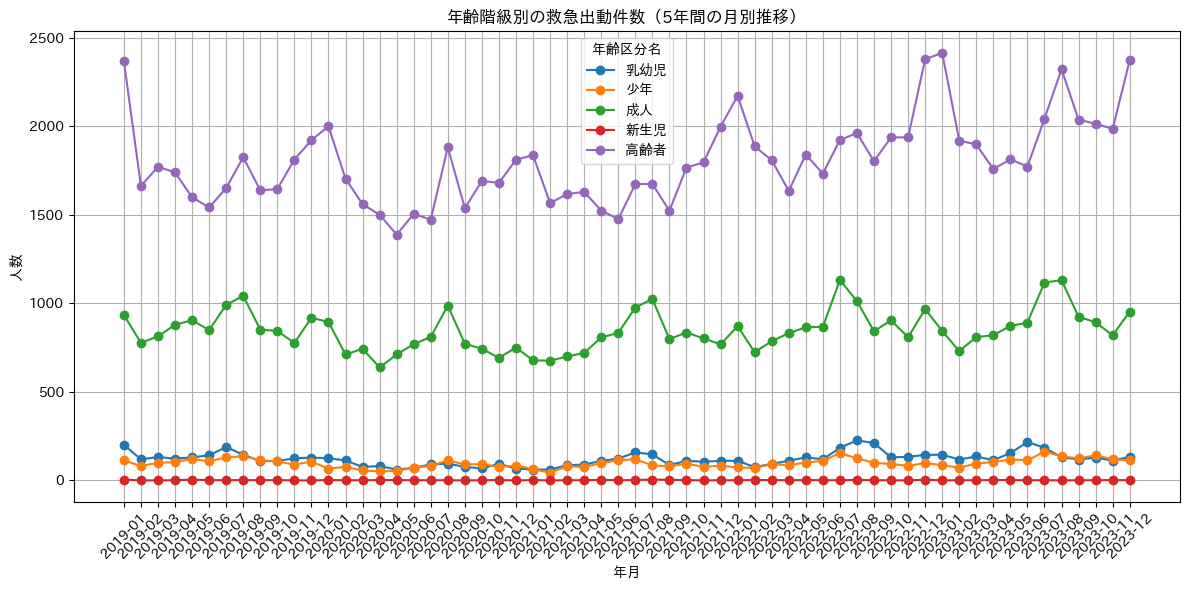

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# `datetime` を日付型に変換（もし未変換の場合）
df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])

# 年月ごとのデータに変換
df_clean['year_month'] = df_clean['datetime'].dt.to_period('M')

# 年齢階級別に月ごとの集計
df_grouped = df_clean.groupby(["year_month", "年齢区分名"])["count"].sum().reset_index()

# ピボットテーブルを作成して、年齢区分ごとに列を分ける
df_pivot = df_grouped.pivot(index="year_month", columns="年齢区分名", values="count").fillna(0)

# グラフの描画
plt.figure(figsize=(12, 6))

# 各年齢階級ごとに折れ線グラフを作成
for age_group in df_pivot.columns:
    plt.plot(df_pivot.index.astype(str), df_pivot[age_group], marker='o', label=age_group)

# グラフの設定
plt.xlabel("年月")
plt.ylabel("人数")
plt.title("年齢階級別の救急出動件数（5年間の月別推移）")
plt.xticks(rotation=45)  # X軸のラベルを回転して見やすく
plt.legend(title="年齢区分名")
plt.grid(True)
plt.tight_layout()

# グラフの表示
plt.show()


<Figure size 1200x600 with 0 Axes>

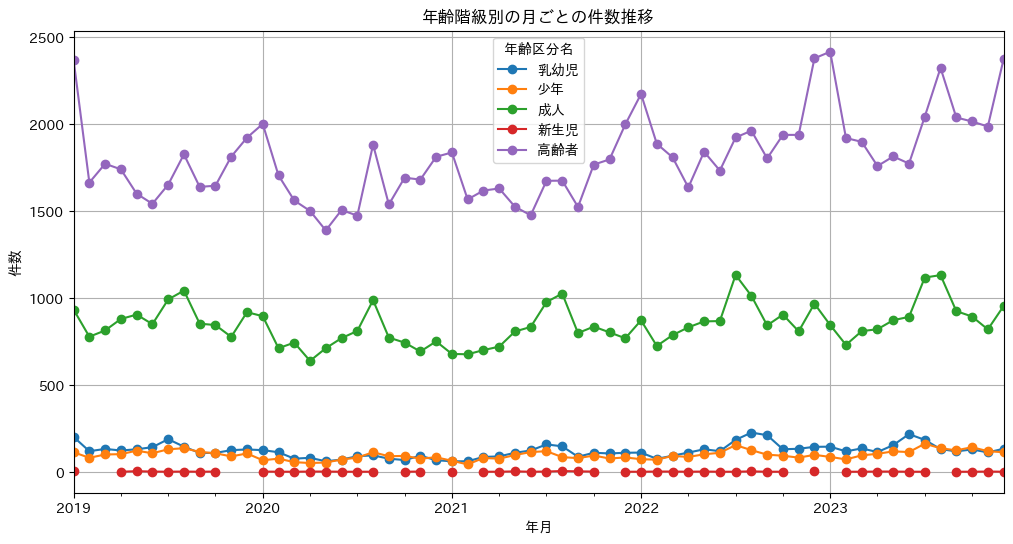

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# データを読み込む（すでにdf_cleanとして存在している前提）
df_clean["datetime"] = pd.to_datetime(df_clean["datetime"])
df_clean["year_month"] = df_clean["datetime"].dt.to_period("M")

# 年齢区分ごとに月ごとの件数を集計
df_grouped = df_clean.groupby(["year_month", "年齢区分名"])["count"].sum().unstack()

# グラフを描画
plt.figure(figsize=(12, 6))
df_grouped.plot(kind="line", marker="o", figsize=(12, 6))

plt.xlabel("年月")
plt.ylabel("件数")
plt.title("年齢階級別の月ごとの件数推移")
plt.legend(title="年齢区分名")
plt.grid(True)

plt.show()


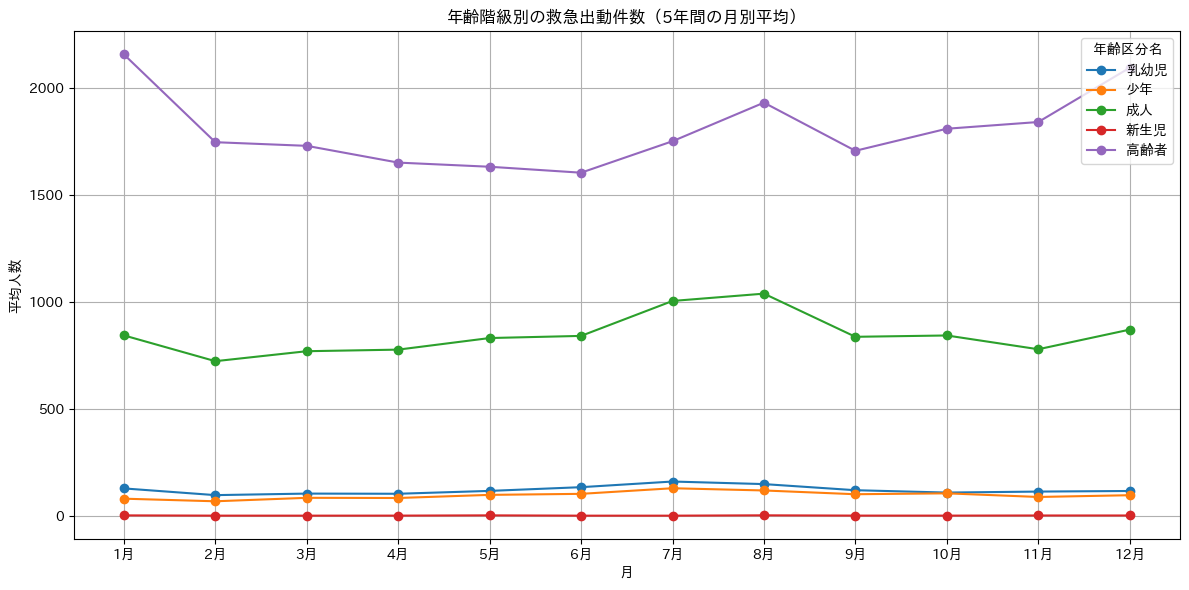

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# `datetime` を日付型に変換（もし未変換の場合）
df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])

# 年月ごとのデータに変換（"YYYY-MM"）
df_clean['year_month'] = df_clean['datetime'].dt.to_period('M')

# 年齢階級別に月ごとの合計を集計
df_grouped = df_clean.groupby(["year_month", "年齢区分名"])["count"].sum().reset_index()

# 各年の同じ月（例えば、1月、2月…）ごとの平均を計算
df_grouped['month'] = df_grouped['year_month'].dt.month  # 月のみ抽出
df_avg = df_grouped.groupby(["month", "年齢区分名"])["count"].mean().reset_index()

# ピボットテーブルを作成して、年齢区分ごとに列を分ける
df_pivot = df_avg.pivot(index="month", columns="年齢区分名", values="count").fillna(0)

# グラフの描画
plt.figure(figsize=(12, 6))

# 各年齢階級ごとに折れ線グラフを作成
for age_group in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[age_group], marker='o', label=age_group)

# グラフの設定
plt.xlabel("月")
plt.ylabel("平均人数")
plt.title("年齢階級別の救急出動件数（5年間の月別平均）")
plt.xticks(range(1, 13), labels=[f"{i}月" for i in range(1, 13)])  # 1月〜12月
plt.legend(title="年齢区分名")
plt.grid(True)
plt.tight_layout()

# グラフの表示
plt.show()


/var/folders/hm/pzckf3v56xn6vlr7p8zrkpf80000gn/T/ipykernel_77657/1545065522.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_clean.groupby(["year_month", "年齢階級"])["count"].sum().reset_index()
/var/folders/hm/pzckf3v56xn6vlr7p8zrkpf80000gn/T/ipykernel_77657/1545065522.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg = df_grouped.groupby(["month", "年齢階級"])["count"].mean().reset_index()


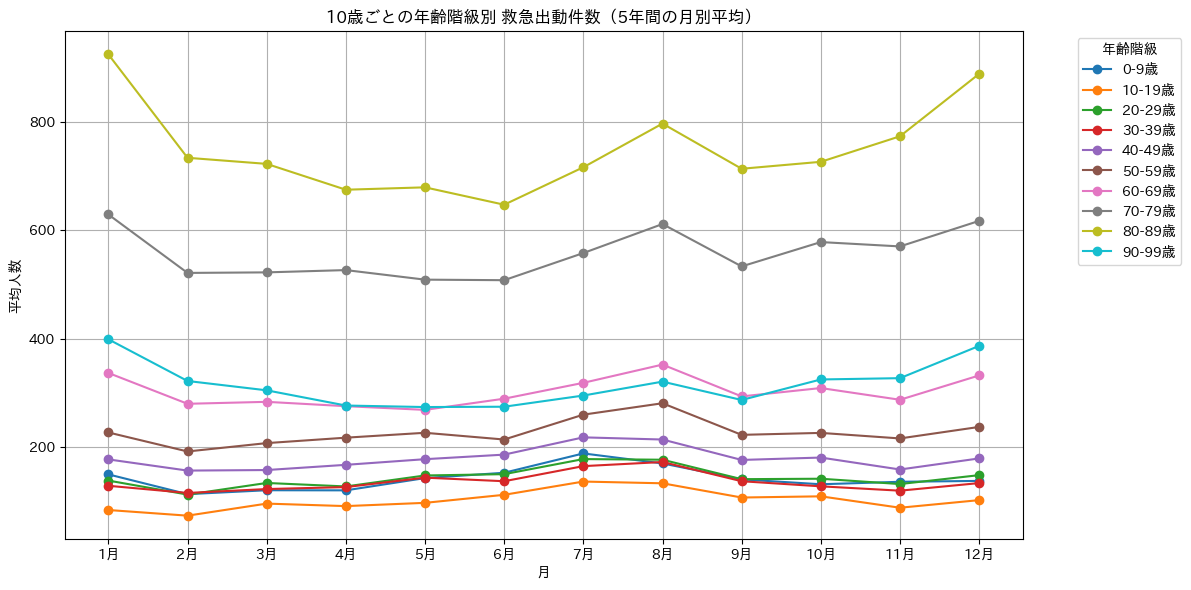

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# `datetime` を日付型に変換（未変換の場合）
df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])

# 年齢を10歳ごとに分類（新しい年齢階級を作成）
bins = list(range(0, 101, 10))  # 0, 10, 20, ..., 100
labels = [f"{i}-{i+9}歳" for i in bins[:-1]]  # "0-9歳", "10-19歳", ...

df_clean['年齢階級'] = pd.cut(df_clean['年齢(歳)'], bins=bins, labels=labels, right=False)

# 年月ごとのデータに変換（"YYYY-MM"）
df_clean['year_month'] = df_clean['datetime'].dt.to_period('M')

# 年齢階級別に月ごとの合計を集計
df_grouped = df_clean.groupby(["year_month", "年齢階級"])["count"].sum().reset_index()

# 月ごとの平均を計算
df_grouped['month'] = df_grouped['year_month'].dt.month  # 月のみ抽出
df_avg = df_grouped.groupby(["month", "年齢階級"])["count"].mean().reset_index()

# ピボットテーブルを作成して、年齢階級ごとに列を分ける
df_pivot = df_avg.pivot(index="month", columns="年齢階級", values="count").fillna(0)

# グラフの描画
plt.figure(figsize=(12, 6))

# 各年齢階級ごとに折れ線グラフを作成
for age_group in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[age_group], marker='o', label=age_group)

# グラフの設定
plt.xlabel("月")
plt.ylabel("平均人数")
plt.title("10歳ごとの年齢階級別 救急出動件数（5年間の月別平均）")
plt.xticks(range(1, 13), labels=[f"{i}月" for i in range(1, 13)])  # 1月〜12月
plt.legend(title="年齢階級", bbox_to_anchor=(1.05, 1), loc="upper left")  # 凡例をグラフ外に
plt.grid(True)
plt.tight_layout()

# グラフの表示
plt.show()


In [17]:
import pandas as pd

# Assuming your data is in a DataFrame called df_clean
age_group_totals = df_clean.groupby("年齢区分名")["count"].sum()
print(age_group_totals)


年齢区分名
乳幼児      7273
少年       5799
成人      50829
新生児        85
高齢者    108334
Name: count, dtype: int64


In [18]:
import pandas as pd

# 年齢を10歳ごとに分類（新しい年齢階級を作成）
bins = list(range(0, 101, 10))  # 0, 10, 20, ..., 100
labels = [f"{i}-{i+9}歳" for i in bins[:-1]]  # "0-9歳", "10-19歳", ...

df_clean['年齢階級'] = pd.cut(df_clean['年齢(歳)'], bins=bins, labels=labels, right=False)

# 各年齢階級ごとの合計人数を算出
age_group_totals = df_clean.groupby("年齢階級")["count"].sum().reset_index()

# 結果を表示
print(age_group_totals)


     年齢階級  count
0    0-9歳   8559
1  10-19歳   6198
2  20-29歳   8679
3  30-39歳   8190
4  40-49歳  10789
5  50-59歳  13670
6  60-69歳  18160
7  70-79歳  33424
8  80-89歳  44963
9  90-99歳  18987


/var/folders/hm/pzckf3v56xn6vlr7p8zrkpf80000gn/T/ipykernel_77657/964593679.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_totals = df_clean.groupby("年齢階級")["count"].sum().reset_index()


In [19]:
import pandas as pd
from scipy.stats import zscore

# 年齢を10歳ごとに分類（新しい年齢階級を作成）
bins = list(range(0, 101, 10))  # 0, 10, 20, ..., 100
labels = [f"{i}-{i+9}歳" for i in bins[:-1]]  # "0-9歳", "10-19歳", ...

df_clean['年齢階級'] = pd.cut(df_clean['年齢(歳)'], bins=bins, labels=labels, right=False)

# 年齢階級ごとに月ごとの合計を集計
df_grouped = df_clean.groupby(["year_month", "年齢階級"])["count"].sum().reset_index()

# 標準化（Zスコア計算）
df_grouped["標準化_count"] = df_grouped.groupby("年齢階級")["count"].transform(zscore)

# ピボットテーブルを作成して、年齢階級ごとに列を分ける
df_pivot = df_grouped.pivot(index="year_month", columns="年齢階級", values="標準化_count").fillna(0)

# 結果を表示
print(df_pivot.head())  # 最初の数行を表示


年齢階級            0-9歳    10-19歳    20-29歳    30-39歳    40-49歳    50-59歳  \
year_month                                                               
2019-01     2.216878  0.109244  0.013208  0.568387  1.827015  0.340706   
2019-02    -0.014802 -0.780895 -0.892488 -0.750271  0.471758 -1.093310   
2019-03     0.235693  0.190166  0.050945 -0.932155 -0.109066 -0.361047   
2019-04     0.007970  0.109244  0.088683  0.204619  0.355593  1.103481   
2019-05     0.668365  0.392470  1.786863  1.705162  0.278150 -0.483091   

年齢階級          60-69歳    70-79歳    80-89歳    90-99歳  
year_month                                          
2019-01     2.129948  2.624780  2.128623  1.453586  
2019-02    -0.371608 -0.810130 -0.401485 -0.602333  
2019-03     0.933552 -0.901727 -0.074163 -0.211539  
2019-04    -0.018127 -0.321609 -0.401485 -0.177557  
2019-05    -0.099700 -0.611668 -0.976510 -1.264985  


/var/folders/hm/pzckf3v56xn6vlr7p8zrkpf80000gn/T/ipykernel_77657/486654150.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_clean.groupby(["year_month", "年齢階級"])["count"].sum().reset_index()
/var/folders/hm/pzckf3v56xn6vlr7p8zrkpf80000gn/T/ipykernel_77657/486654150.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped["標準化_count"] = df_grouped.groupby("年齢階級")["count"].transform(zscore)


In [20]:
import re
# float型の値を文字列に変換し、NANを適切に処理
def preprocess_disease_name(name):
    if pd.isna(name):
        return "不明"
    if isinstance(name, (int, float)):
        return str(int(name))
    return str(name)

df_categolized = df_clean.copy()
df_categolized['傷病名'] = df_categolized['傷病名'].apply(preprocess_disease_name)

# 傷病名の正規化関数
def simplify_disease_name(name):
    
    # 括弧内の詳細情報を除去
    name = re.sub(r'[\(（].*?[\)）]', '', name)
    # 疑いの表現を統一
    name = re.sub(r'(の疑い|疑い|疑|と思われる)', '疑い', name)
    return name.strip()

#疼痛について、運動器の痛みは整形外科にした
#外傷について、硬膜外血腫は神経に入れた
# 分類ルール
rules = {
    '外傷系': r'(咬傷|骨折|打撲|裂傷|挫傷|外傷|脱臼|擦過傷|刺傷|切創|挫創|熱傷|捻挫|脳震盪|心臓震盪|頸髄損傷|頚椎損傷|脊髄損傷|頸椎損傷|頭部血腫|圧挫症候群|腹腔内出血)',
    '整形外科':r'(腰痛|椎間板ヘルニア|頸椎ヘルニア|腰椎ヘルニア|椎症|脊柱管狭窄症|坐骨神経痛|肋間神経痛|関節痛|膝部痛|膝痛|大腿部痛|下肢痛|関節炎|関節症|腱断裂|リウマチ)',
    '循環器系': r'(硬膜外血腫|大動脈解離|大動脈瘤|大動脈瘤破裂|心筋梗塞|虚血性心疾患|急性冠症候群|不整脈|高血圧|狭心症|心不全|心筋症|血圧|房室ブロック|心房細動|心房粗動|心室頻拍|上室性頻拍|洞性頻脈|上室頻拍|心室性期外収縮|肺血栓塞栓症|肺塞栓症|洞不全症候群|徐脈|弁狭窄|弁閉鎖不全|深部静脈血栓症)',
    '脳神経系': r'(脳卒中|脳梗塞|ラクナ梗塞|脳幹梗塞|心原性脳塞栓症|脳幹出血|被殻出血|視床出血|皮質下出血|脳血管障害|脳動脈瘤|脳出血|くも膜下出血|脳腫瘍|水頭症|てんかん|痙攣|意識障害|頭痛|脳虚血|ＴＩＡ|パーキンソン|けいれん|構音障害|呂律障害|痺れ|歩行障害|神経麻痺|筋萎縮性側索硬化症)',
    '消化器系': r'(腹痛|胃炎|胆石|腸炎|下痢|嘔吐|消化管|吐血|下血|血便|急性腹症|腸|イレウス|胆管|胆嚢|胆のう|腹膜炎|憩室炎|虫垂炎|食道静脈瘤|マロリーワイス症候群|憩室出血|消化器出血|逆流性食道炎|胃潰瘍|急性胃粘膜病変|潰瘍性大腸炎|クローン|膵炎|肝硬変|肝機能障害|閉塞性黄疸|肝性脳症|膵臓癌|膵癌|胃癌|肝癌|肝臓癌|食道癌|食道裂孔ヘルニア|鼠径ヘルニア|肝臓癌|肝膿瘍)',
    '呼吸器系': r'(肺炎|気管支炎|喘息|呼吸困難|咳|痰|気道|過換気|肺癌|肺がん|慢性閉塞性肺疾患|気管支拡張症|ＣＯＰＤ|ＣＯ２ナルコーシス|肺気腫|気胸|胸膜炎|膿胸|乳癌)',
    '血液内科': r'(リンパ腫|白血病|多発性骨髄腫|再生不良性貧血|特発性血小板減少性紫斑病|悪性リンパ腫|骨髄異形成症候群|骨髄線維症|骨髄腫|血小板減少|白血球減少|汎血球減少|血友病|溶血性貧血|ヘモグロビン低下|鉄欠乏性貧血|溶血|血栓性血小板減少性紫斑病)',
    '感染症': r'(感染症|敗血症|髄膜炎|発熱|熱発|インフルエンザ|咽頭炎|感冒|悪寒|蜂窩織炎|帯状疱疹|非結核性抗酸菌症|扁桃炎|扁桃周囲膿瘍|急性喉頭蓋炎)',
    '代謝系': r'(糖尿病|電解質|脱水|低血糖|高血糖|痛風|偽痛風|低カリウム血症|低ナトリウム血症|高カリウム血症|高アンモニア血症)',
    '中毒': r'(中毒|過量摂取|アルコール|薬物)',
    '精神系': r'(統合失調|双極性障害|うつ病|不安|精神|認知症|心因反応|解離性障害|パニック障害|パニック発作|せん妄|うつ病|鬱病|不眠症|適応障害)',
    '産婦人科系': r'(分娩|妊娠|流産|性器出血|流産|早産|切迫流産|陣痛|切迫早産|生理痛|月経痛|月経困難症|破水|子宮筋腫|卵巣|子宮)',
    '小児科系': r'(熱性痙攣|百日咳|川崎病|クループ症候群)',
    '泌尿器系': r'(腎臓癌|腎癌|膀胱|尿|前立腺|排尿|水腎|腎盂腎炎|腎結石)',
    '耳鼻科系': r'(鼻出血|メニエール|末梢性眩暈)',
    '老年' : r'(便秘|誤嚥|衰弱|体動困難|歩行困難|起立困難|老衰|褥瘡|廃用症候群)',
    '非特異的愁訴' : r'(喀血|嘔気|悪心|振戦|不随意運動|食欲不振|食思不振|貧血|黄疸|めまい|過呼吸|動悸|呼吸苦|気分不快|胸部不快感|胸部違和感|胸部圧迫感|倦怠感|頭重感|自律神経失調症|ふらつき|全身の痛み|全身の震え|新型コロナワクチン副反応)',
    '心肺停止' : r'(心肺停止|ＣＰＡ|心停止)',
    '腎不全' : r'(腎不全)',
    '痛み' : r'(広背筋痛|下腹部痛|上腹部痛|胃痛|背部痛|心窩部痛|胸部痛|胸痛|後頸部痛|腰部痛|頸部痛|季肋部痛|左側腹部痛|右側腹部痛|胸部絞扼感|後頭部痛)',
    '非外傷性救急' : r'(溺水|呼吸不全|窒息|誤飲|失神|意識消失|肺水腫|胸水貯留|胸水|アナフィラキシー|薬疹|アレルギー|蕁麻疹|ショック|迷走神経反射|脱力|不明熱|低体温|熱中症|低酸素血症|横紋筋融解症|栄養失調|低栄養)',
    '自損' : r'(自殺|自傷|縊頸|過量服薬|多量服薬)',

}

# 分類関数
def classify_disease(name):
    for category, pattern in rules.items():
        if re.search(pattern, name):
            return category
    return 'その他'

# 傷病名の正規化
df_categolized['normalized_name'] = df_categolized['傷病名'].apply(simplify_disease_name)

# 分類の実行
df_categolized['category'] = df_categolized['normalized_name'].apply(classify_disease)


/var/folders/hm/pzckf3v56xn6vlr7p8zrkpf80000gn/T/ipykernel_77657/1012956274.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_clean.groupby(["year_month", "年齢階級"])["count"].sum().reset_index()
/var/folders/hm/pzckf3v56xn6vlr7p8zrkpf80000gn/T/ipykernel_77657/1012956274.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped["標準化_count"] = df_grouped.groupby("年齢階級")["count"].transform(zscore)


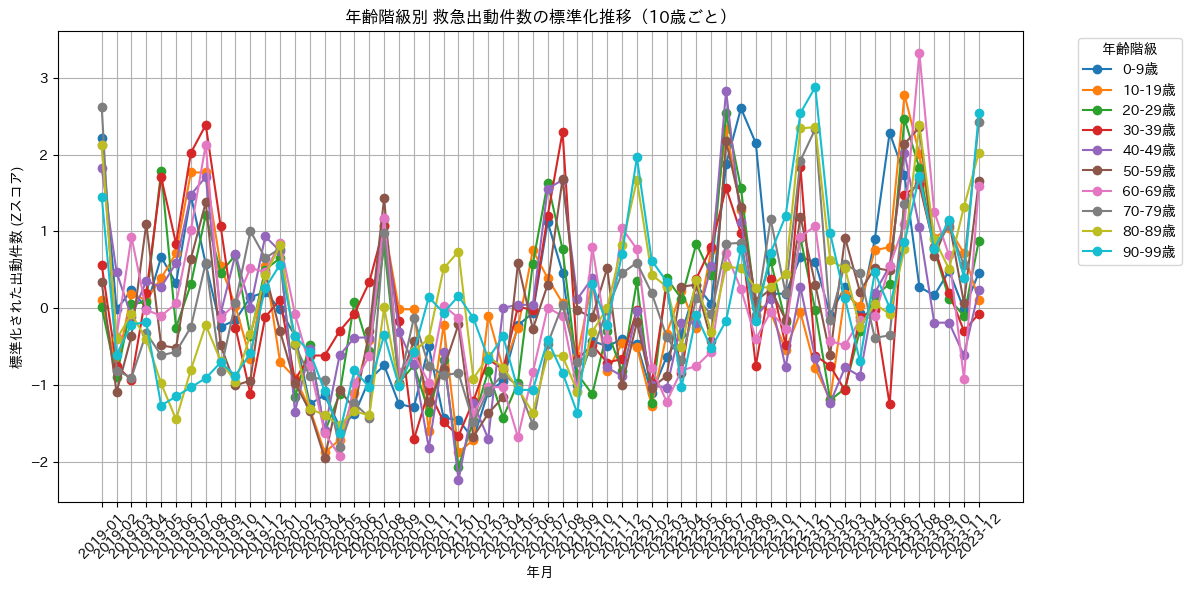

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore

# `datetime` を日付型に変換（未変換の場合）
df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])

# 年齢を10歳ごとに分類（新しい年齢階級を作成）
bins = list(range(0, 101, 10))  # 0, 10, 20, ..., 100
labels = [f"{i}-{i+9}歳" for i in bins[:-1]]  # "0-9歳", "10-19歳", ...

df_clean['年齢階級'] = pd.cut(df_clean['年齢(歳)'], bins=bins, labels=labels, right=False)

# 年月ごとのデータに変換（"YYYY-MM"）
df_clean['year_month'] = df_clean['datetime'].dt.to_period('M')

# 年齢階級ごとに月ごとの合計を集計
df_grouped = df_clean.groupby(["year_month", "年齢階級"])["count"].sum().reset_index()

# 標準化（Zスコア計算）
df_grouped["標準化_count"] = df_grouped.groupby("年齢階級")["count"].transform(zscore)

# ピボットテーブルを作成して、年齢階級ごとに列を分ける
df_pivot = df_grouped.pivot(index="year_month", columns="年齢階級", values="標準化_count").fillna(0)

# グラフの描画
plt.figure(figsize=(12, 6))

# 各年齢階級ごとに折れ線グラフを作成
for age_group in df_pivot.columns:
    plt.plot(df_pivot.index.astype(str), df_pivot[age_group], marker='o', label=age_group)

# グラフの設定
plt.xlabel("年月")
plt.ylabel("標準化された出動件数 (Zスコア)")
plt.title("年齢階級別 救急出動件数の標準化推移（10歳ごと）")
plt.xticks(rotation=45)  # X軸のラベルを回転して見やすく
plt.legend(title="年齢階級", bbox_to_anchor=(1.05, 1), loc="upper left")  # 凡例をグラフ外に
plt.grid(True)
plt.tight_layout()

# グラフの表示
plt.show()


/var/folders/hm/pzckf3v56xn6vlr7p8zrkpf80000gn/T/ipykernel_77657/1109292244.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_clean.groupby(["year_month", "年齢階級"])["count"].sum().reset_index()
/var/folders/hm/pzckf3v56xn6vlr7p8zrkpf80000gn/T/ipykernel_77657/1109292244.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped["標準化_count"] = df_grouped.groupby("年齢階級")["count"].transform(zscore)
/var/folders/hm/pzckf3v56xn6vlr7p8zrkpf80000gn/T/ipykernel_77657/1109292244.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

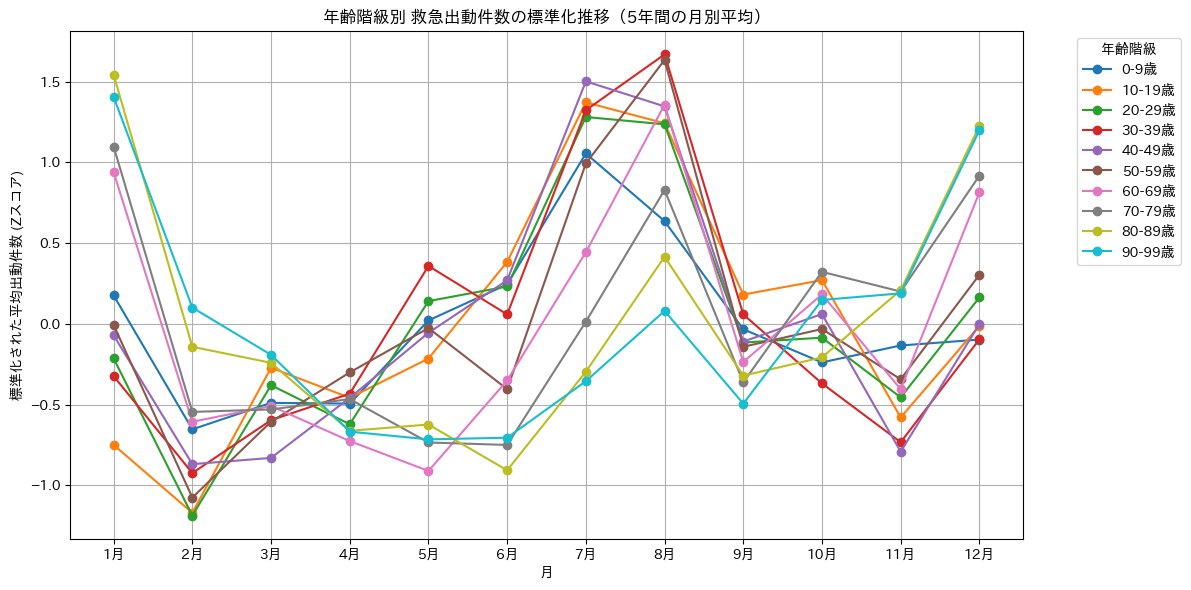

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore

# `datetime` を日付型に変換（未変換の場合）
df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])

# 年齢を10歳ごとに分類（新しい年齢階級を作成）
bins = list(range(0, 101, 10))  # 0, 10, 20, ..., 100
labels = [f"{i}-{i+9}歳" for i in bins[:-1]]  # "0-9歳", "10-19歳", ...

df_clean['年齢階級'] = pd.cut(df_clean['年齢(歳)'], bins=bins, labels=labels, right=False)

# 年月ごとのデータに変換（"YYYY-MM"）
df_clean['year_month'] = df_clean['datetime'].dt.to_period('M')

# 年齢階級ごとに月ごとの合計を集計
df_grouped = df_clean.groupby(["year_month", "年齢階級"])["count"].sum().reset_index()

# 月だけを抽出（1月, 2月, ... 12月）
df_grouped['month'] = df_grouped['year_month'].dt.month

# 各年齢階級ごとに Zスコア（標準化）
df_grouped["標準化_count"] = df_grouped.groupby("年齢階級")["count"].transform(zscore)

# 5年間の月ごとの平均を計算
df_avg = df_grouped.groupby(["month", "年齢階級"])["標準化_count"].mean().reset_index()

# ピボットテーブルを作成して、年齢階級ごとに列を分ける
df_pivot = df_avg.pivot(index="month", columns="年齢階級", values="標準化_count").fillna(0)

# グラフの描画
plt.figure(figsize=(12, 6))

# 各年齢階級ごとに折れ線グラフを作成
for age_group in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[age_group], marker='o', label=age_group)

# グラフの設定
plt.xlabel("月")
plt.ylabel("標準化された平均出動件数 (Zスコア)")
plt.title("年齢階級別 救急出動件数の標準化推移（5年間の月別平均）")
plt.xticks(range(1, 13), labels=[f"{i}月" for i in range(1, 13)])  # 1月〜12月
plt.legend(title="年齢階級", bbox_to_anchor=(1.05, 1), loc="upper left")  # 凡例をグラフ外に
plt.grid(True)
plt.tight_layout()

# グラフの表示
plt.show()
